## Part 1

In [ ]:
# Install general dependencies
import os
import sys
import json
import subprocess
import numpy as np
import pandas as pd
import h5py
import urllib
from IPython.display import display, clear_output
from PIL import Image
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import pickle as pk
from sklearn.metrics import classification_report, confusion_matrix

# Install Keras dependencies
from keras.utils.data_utils import get_file
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [7]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [2]:
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [3]:
vgg16 = VGG16(weights='imagenet')
vgg16.save('vgg16.h5')
resnet50 = ResNet50(weights='imagenet')
vgg19 = VGG19(weights='imagenet')
inception = InceptionV3(weights='imagenet')

In [5]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [69]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [8]:
y = prepare_image('test.jpg')
preds = vgg16.predict(y)
print(get_predictions(preds, top=5))

40960/35363 [==================================] - 0s 1us/step
[[('n02974003', 'car_wheel', 0.803549), ('n04037443', 'racer', 0.038957883), ('n03594945', 'jeep', 0.015953451), ('n04252225', 'snowplow', 0.011781851), ('n03769881', 'minibus', 0.01134586)]]


In [14]:
z = preprocess_input(y)
preds = resnet50.predict(z)
print(get_predictions(preds))

[[('n04153751', 'screw', 0.69939107), ('n02974003', 'car_wheel', 0.09457172), ('n03804744', 'nail', 0.078896545), ('n03424325', 'gasmask', 0.037948087), ('n02788148', 'bannister', 0.024410771)]]


In [15]:
a = preprocess_input(y)
preds = vgg19.predict(a)
print(get_predictions(preds))

[[('n02974003', 'car_wheel', 0.99938464), ('n03594945', 'jeep', 0.00015146732), ('n03670208', 'limousine', 0.00010930089), ('n03459775', 'grille', 9.8135846e-05), ('n03770679', 'minivan', 7.8952944e-05)]]


In [57]:
# VGG16 as a gate
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('data')
    for i, img_path in enumerate(img_list):
        img = prepare_image('data/'+img_path)
        remove_ds_store = 'find . -name ''.DS_Store'' -type f -delete'
        subprocess.Popen(remove_ds_store, shell=True)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 50 == 0:
            print(i, '/', len(img_list), 'complete')
    return Counter(d)

In [58]:
car_counter = get_car_categories()

0 / 56 complete
50 / 56 complete


## Part 2 (Damaged vehicles vs non-damaged vehicles)

In [88]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1
from keras.models import Sequential, load_model
# from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import ZeroPadding2D
# from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [138]:
def load_vgg16(weights_path='data/vgg16_weights.h5'):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(img_width, img_height, 3)))
#     model.add(ZeroPadding2D((1,1),input_shape=(3, img_width, img_height)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format="channels_first"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format="channels_first"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format="channels_first"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format="channels_first"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format="channels_first"))
    
    if weights_path:
        model.load_weights(weights_path, by_name=True)
        print('VGG16 Model with partial weights loaded.')
    else:
        print('VGG16 Model with no weights Loaded.')
    # note: this chops off the last layers of VGG16 

    # loads the weights of the VGG16 networks
    # note: when there is a complete match between model definition
    # and your weights savefile, you can simply call model.load_weights(filename)
#         f = h5py.File(weights_path)
#         for k in range(f.attrs['nb_layers']):
#             if k >= len(model.layers): 
#                 # we don't look at the last (fully-connected) layers in the savefile
#                 break
#             g = f['layer_{}'.format(k)]
#             weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
#             model.layers[k].set_weights(weights)
#         f.close()
#         print('VGG16 Model with partial weights loaded.')
#     else:
#         print('VGG16 Model with no weights Loaded.')

    return model


def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = load_vgg16()
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16, 
                                            class_mode=None, 
                                            shuffle=False) 
    
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
#     np.save(open(location+'/features_train.npy', 'w'), bottleneck_features_train)
    np.save(location+'/features_train.npy', bottleneck_features_train)
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16,
                                            class_mode=None,
                                            shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
#     np.save(open(location+'/bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)
    np.save(location+'/features_validation.npy', bottleneck_features_validation)

    
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print("Best Model:")
    print_best_model_results(hist)
    

def train_binary_model():
    train_data = np.load(open(location+'/bottleneck_features_train.npy'))
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(open(location+'/bottleneck_features_validation.npy'))
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu', W_regularizer=l2(0.01)))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history


def finetune_binary_model():
    model = load_vgg16()

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', W_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base
    model.add(top_model)
    
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False

    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    model.compile(loss='binary_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='binary')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
    # fine-tune the model
    fit = model.fit_generator(train_generator,
                              samples_per_epoch=nb_train_samples,
                              nb_epoch=nb_epoch,
                              validation_data=validation_generator,
                              nb_val_samples=nb_validation_samples,
                              verbose=1,
                              callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history


def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary', # categorical for multiclass
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    # use for multiclass
    # pred_labels = np.argmax(predictions, axis=1)
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='g')
    

def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        imge = Image.open(img_dir+img)
        import IPython.display as display
        display.display(imge)
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'
        

def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_acc'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [66]:
pwd

'/Users/tylerbailey/Desktop/ds_projects/Vehicle_Damage_Deep_Learning'

In [67]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest') # omitted rescaling to keep the images displayable

img = load_img('notebooks/test.jpg') # this is a PIL image 
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the 'preview/' directory
os.makedirs('data_preview')

i = 0
for batch in datagen.flow(x, 
                          batch_size=1,
                          save_to_dir='data_preview', 
                          save_prefix='damage_car',
                          save_format='jpeg'):
    i +=1
    if i > 30:
        break # otherwise the generator would loop indefinitely

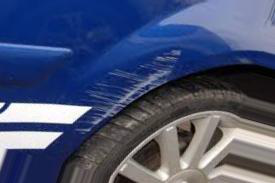

c to continue, q to quit q


'Finished for now.'

In [76]:
view_images('data_preview/', os.listdir('data_preview/'))

In [118]:
# path to the model weights file
location = 'data'
top_model_weights_path = location + '/top_model_weights.h5' 
fine_tuned_model_path = location + '/ft_model.h5'

img_width, img_height = 256, 256

train_data_dir = location + '/training'
validation_data_dir = location + '/validation'

_, _, train_files = next(os.walk(train_data_dir))
train_samples = len(train_files)
# train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = train_samples

_, _, validation_files = next(os.walk(validation_data_dir))
validation_samples = len(validation_files)
# validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = validation_samples

nb_epoch = 50

In [139]:
save_bottleneck_features(location)

VGG16 Model with partial weights loaded.
Found 45 images belonging to 1 classes.


KeyboardInterrupt: 